# Introduction

This kernel combines XGBoost and LightGBM models together. It uses hand tuned XGBoost and LightGBM models to do so. It searches for the optimal combination of models to produce a blended combination of both. No extensive feature engineering is performed. In this instance we'll use 3 different models:

* LightGBM with `LabelEncode`.
* XGBoost with `LeaveOneOut` encoding.
* XGBoost with `LeaveOneOut` encoding and `MEstimateEncoder`.

## Credits

* [LGBM Goes brrr!](https://www.kaggle.com/maunish/lgbm-goes-brrr) for tuned LGBM parameters.

In [11]:
import pandas as pd
import numpy as np
from scipy import stats

from datetime import datetime

train = pd.read_csv('..\\kaggle_data\\train.csv')
test = pd.read_csv('..\\kaggle_data\\test.csv')
#train = train[(np.abs(stats.zscore(train['target'])) < 3.0)]
train

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,499993,A,B,A,C,B,B,A,E,E,...,0.269578,0.258655,0.363598,0.300619,0.340516,0.235711,0.383477,0.215227,0.793630,8.343538
299996,499996,A,B,A,C,B,B,A,E,E,...,0.197211,0.257024,0.574304,0.227035,0.322583,0.286094,0.324874,0.306933,0.230902,7.851861
299997,499997,A,B,A,C,B,B,A,E,C,...,0.449482,0.386172,0.476217,0.135947,0.502730,0.235788,0.316671,0.250286,0.349041,7.600558
299998,499998,A,B,B,C,B,B,A,D,E,...,0.363130,0.324132,0.229017,0.220888,0.515304,0.389391,0.245234,0.303895,0.481138,8.272095


# Feature Engineering

In [12]:
cat_features = [
    "cat0", "cat1", "cat2", "cat3", "cat4", "cat5", "cat6", "cat7", 
    "cat8", "cat9"
]

cont_features = [
    "cont0", "cont1", "cont2", "cont3", "cont4",
    "cont5", "cont6", "cont7", "cont8", "cont9", "cont10", 
    "cont11", "cont12", "cont13"
]

In [13]:
!pip install category-encoders

You should consider upgrading via the 'c:\users\ryans\source\repos\venvs\python375\scripts\python.exe -m pip install --upgrade pip' command.


In [14]:
from sklearn.preprocessing import LabelEncoder
from category_encoders import LeaveOneOutEncoder
from category_encoders import MEstimateEncoder

lgb_cat_features = []
xgb1_cat_features = []
xgb2_cat_features = []

def label_encode(train_df, test_df, column):
    le = LabelEncoder()
    new_feature = "{}_le".format(column)
    le.fit(train_df[column])
    train_df[new_feature] = le.transform(train_df[column])
    test_df[new_feature] = le.transform(test_df[column])
    return new_feature

def loo_encode(train_df, test_df, column):
    loo = LeaveOneOutEncoder()
    new_feature = "{}_loo".format(column)
    loo.fit(train_df[column], train_df["target"])
    train_df[new_feature] = loo.transform(train_df[column])
    test_df[new_feature] = loo.transform(test_df[column])
    return new_feature

def mee_encode(train_df, test_df, column):
    mee = MEstimateEncoder()
    new_feature = "{}_mee".format(column)
    mee.fit(train_df[column], train_df["target"])
    train_df[new_feature] = mee.transform(train_df[column])
    test_df[new_feature] = mee.transform(test_df[column])
    return new_feature

for feature in cat_features:
    lgb_cat_features.append(label_encode(train, test, feature))

for feature in cat_features:
    xgb1_cat_features.append(loo_encode(train, test, feature))
    
xgb2_cat_features.extend(xgb1_cat_features)
for feature in cat_features:
    xgb2_cat_features.append(mee_encode(train, test, feature))

train

c:\users\ryans\source\repos\venvs\python375\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cat0_mee,cat1_mee,cat2_mee,cat3_mee,cat4_mee,cat5_mee,cat6_mee,cat7_mee,cat8_mee,cat9_mee
0,1,A,B,A,A,B,D,A,E,C,...,7.468577,7.573733,7.430033,7.383022,7.455725,7.475468,7.448407,7.451873,7.447993,7.323653
1,2,B,A,A,A,B,B,A,E,A,...,7.269165,7.357098,7.430033,7.383022,7.455725,7.462829,7.448407,7.451873,7.475537,7.480613
2,3,A,A,A,C,B,D,A,B,C,...,7.468577,7.357098,7.430033,7.498493,7.455725,7.475468,7.448407,7.487698,7.447993,7.461630
3,4,A,A,A,C,B,D,A,E,G,...,7.468577,7.357098,7.430033,7.498493,7.455725,7.475468,7.448407,7.451873,7.324929,7.398033
4,6,A,B,A,A,B,B,A,E,C,...,7.468577,7.573733,7.430033,7.383022,7.455725,7.462829,7.448407,7.451873,7.447993,7.480613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,499993,A,B,A,C,B,B,A,E,E,...,7.468577,7.573733,7.430033,7.498493,7.455725,7.462829,7.448407,7.451873,7.516123,7.634494
299996,499996,A,B,A,C,B,B,A,E,E,...,7.468577,7.573733,7.430033,7.498493,7.455725,7.462829,7.448407,7.451873,7.516123,7.634494
299997,499997,A,B,A,C,B,B,A,E,C,...,7.468577,7.573733,7.430033,7.498493,7.455725,7.462829,7.448407,7.451873,7.447993,7.475809
299998,499998,A,B,B,C,B,B,A,D,E,...,7.468577,7.573733,7.765573,7.498493,7.455725,7.462829,7.448407,7.497051,7.516123,7.480613


In [15]:
len(train.index)

300000

# Build Models

Here we will build 3 models - one LightGBM model and two XGBoost models. We'll save the results of each model separately so we can try different combinations of both later. We'll use out-of-fold predictions for the test set for better results.

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

n_folds = 10

skf = KFold(n_splits=n_folds, random_state=2021, shuffle=True)

lgb_train_oof = np.zeros((len(train.index),))
xgb1_train_oof = np.zeros((len(train.index),))
xgb2_train_oof = np.zeros((len(train.index),))

lgb_test_preds = 0
xgb1_test_preds = 0
xgb2_test_preds = 0

full_features = []
full_features.extend(lgb_cat_features)
full_features.extend(xgb2_cat_features)
full_features.extend(cont_features)

lgb_features = []
lgb_features.extend(lgb_cat_features)
lgb_features.extend(cont_features)

xgb1_features = []
xgb1_features.extend(xgb1_cat_features)
xgb1_features.extend(cont_features)

xgb2_features = []
xgb2_features.extend(xgb2_cat_features)
xgb2_features.extend(cont_features)

lgb_params = {
    "random_state": 2021,
    "metric": "rmse",
    "n_jobs": -1,
    "cat_feature": [x for x in range(len(lgb_cat_features))],
    "early_stopping_round": 150,
    "reg_alpha": 6.147694913504962,
    "reg_lambda": 0.002457826062076097,
    "colsample_bytree": 0.3,
    "learning_rate": 0.01,
    "max_depth": 30,
    "num_leaves": 100,
    "min_child_samples": 275,
    "n_estimators": 1600000,
    "cat_smooth": 40.0,
    "max_bin": 512,
    "min_data_per_group": 100,
    "bagging_freq": 1,
    "bagging_fraction": 0.7,
    "cat_l2": 12.0,
}

xgb1_params = {
    "seed": 2021,
    "n_estimators": 10000,
    "verbosity": 1,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "gpu_hist", 
    "gpu_id": 0,
    "colsample_bytree": 0.23116058185789234, 
    "gamma": 2.0737266506535375, 
    "lambda": 8.76288374058159, 
    "learning_rate": 0.01126802018395814, 
    "max_depth": 5, 
    "min_child_weight": 1.4477515824904934, 
    "subsample": 0.4898608703522127,
    "alpha": 9.206528646529561,
    "max_bin": 658,
}

xgb2_params = {
    "seed": 2021,
    "n_estimators": 10000,
    "verbosity": 1,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "gpu_hist", 
    "gpu_id": 0,
    "colsample_bytree": 0.21428906671248488, 
    "gamma": 2.116597615713485, 
    "lambda": 6.683336764226128, 
    "learning_rate": 0.008098678089211109, 
    "max_depth": 11, 
    "min_child_weight": 7.587302445130359, 
    "subsample": 0.6309499238527587,
    "alpha": 8.078271293205107,
    "max_bin": 570,
}

for fold, (train_index, test_index) in enumerate(skf.split(train, train["target"])):
    print("-------> Fold {} <--------".format(fold + 1))
    x_train, x_valid = pd.DataFrame(train.iloc[train_index]), pd.DataFrame(train.iloc[test_index])
    y_train, y_valid = train["target"].iloc[train_index], train["target"].iloc[test_index]
    
    x_train_features = pd.DataFrame(x_train[full_features])
    x_valid_features = pd.DataFrame(x_valid[full_features])

    print(": Build LightGBM model")
    lgb_model = LGBMRegressor(
        **lgb_params
    )
    lgb_model.fit(
        x_train_features[lgb_features], 
        y_train,
        eval_set=[(x_valid_features[lgb_features], y_valid)],
        verbose=500,
    )
    
    print("")
    print(": Build XGBoost model 1")
    xgb1_model = XGBRegressor(
        **xgb1_params
    )
    xgb1_model.fit(
        x_train_features[xgb1_features], 
        y_train,
        eval_set=[(x_valid_features[xgb1_features], y_valid)],
        verbose=500,
        early_stopping_rounds=200,
    )

    print("")
    print(": Build XGBoost model 2")
    xgb2_model = XGBRegressor(
        **xgb2_params
    )
    xgb2_model.fit(
        x_train_features[xgb2_features], 
        y_train,
        eval_set=[(x_valid_features[xgb2_features], y_valid)],
        verbose=500,
        early_stopping_rounds=200,
    )
    
    lgb_oof_preds = lgb_model.predict(x_valid_features[lgb_features])
    lgb_train_oof[test_index] = lgb_oof_preds

    xgb1_oof_preds = xgb1_model.predict(x_valid_features[xgb1_features])
    xgb1_train_oof[test_index] = xgb1_oof_preds

    xgb2_oof_preds = xgb2_model.predict(x_valid_features[xgb2_features])
    xgb2_train_oof[test_index] = xgb2_oof_preds

    lgb_test_preds += lgb_model.predict(test[lgb_features]) / n_folds
    xgb1_test_preds += xgb1_model.predict(test[xgb1_features]) / n_folds
    xgb2_test_preds += xgb2_model.predict(test[xgb2_features]) / n_folds
    print("")
    
print("--> Overall results for out of fold predictions")
print(": LGB RMSE = {}".format(mean_squared_error(lgb_train_oof, train["target"], squared=False)))
print(": XGB 1 RMSE = {}".format(mean_squared_error(xgb1_train_oof, train["target"], squared=False)))
print(": XGB 2 RMSE = {}".format(mean_squared_error(xgb2_train_oof, train["target"], squared=False)))

-------> Fold 1 <--------
: Build LightGBM model
[500]	valid_0's rmse: 0.854955
[1000]	valid_0's rmse: 0.848003
[1500]	valid_0's rmse: 0.845528
[2000]	valid_0's rmse: 0.844351
[2500]	valid_0's rmse: 0.843844
[3000]	valid_0's rmse: 0.843683

: Build XGBoost model 1
[0]	validation_0-rmse:6.97277
[500]	validation_0-rmse:0.92533
[1000]	validation_0-rmse:0.85223
[1500]	validation_0-rmse:0.84881
[2000]	validation_0-rmse:0.84694
[2500]	validation_0-rmse:0.84579
[3000]	validation_0-rmse:0.84508
[3500]	validation_0-rmse:0.84458
[4000]	validation_0-rmse:0.84427
[4500]	validation_0-rmse:0.84407
[5000]	validation_0-rmse:0.84395
[5500]	validation_0-rmse:0.84388
[6000]	validation_0-rmse:0.84382
[6381]	validation_0-rmse:0.84382

: Build XGBoost model 2
[0]	validation_0-rmse:6.94517
[500]	validation_0-rmse:0.85255
[1000]	validation_0-rmse:0.84572
[1500]	validation_0-rmse:0.84413
[2000]	validation_0-rmse:0.84363
[2500]	validation_0-rmse:0.84353
[2803]	validation_0-rmse:0.84353

-------> Fold 2 <-------

# Find Best Combo

Now we'll search for the best split between the LightGBM model and the XGBoost model. We'll plot the results and make sure there aren't any additional useful combinations to check out besides the best looking one.

In [17]:
best_split_rmse = 9999999.9
best_split_combo = -1

split_results = []
split_percentages = []
split_strings = []
index = 0

print("--> Calculating best combination")
splits = []
for x in range(100, 0, -5):
    if 100 - x == 0:
        splits.append([x / 100., 0., 0.])
    for y in range(100 - x, 0, -5):
        if 100 - x - y == 0 and x + y == 100:
            splits.append([x / 100., y / 100., 0.])
            splits.append([x / 100., 0., y / 100.])
        for z in range(100 - x - y, 0, -5):
            if x + y + z == 100:
                splits.append([x /100., y / 100., z / 100.])
            
for index, x in enumerate(splits):
    combo_preds = (x[0] * lgb_train_oof) + (x[1] * xgb1_train_oof) + (x[2] * xgb2_train_oof)
    rmse = mean_squared_error(combo_preds, train["target"], squared=False)
    split_results.append(rmse)
    split_strings.append("LGB {:0.3} + XGB1 {:0.3} + XGB2 {:0.3}".format(x[0], x[1], x[2]))
    split_percentages.append(x)
    if rmse < best_split_rmse:
        best_split_rmse = rmse
        best_split_combo = index
    
print(": Best combo is {}".format(split_strings[best_split_combo]))
print(": Best RMSE is {}".format(best_split_rmse))

--> Calculating best combination
: Best combo is LGB 0.35 + XGB1 0.15 + XGB2 0.5
: Best RMSE is 0.8423803686920549


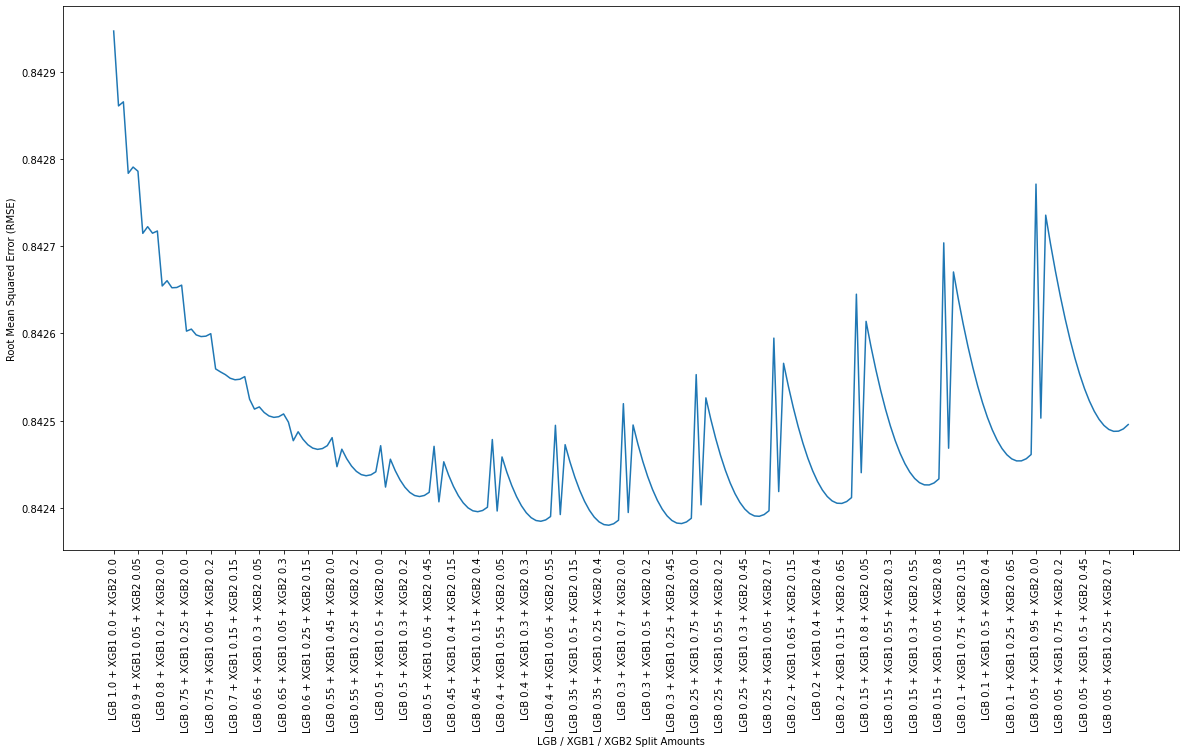

In [18]:
import matplotlib.pyplot as plt 
%matplotlib inline

labels = [x if index % 5 == 0 else " " for index, x in enumerate(split_strings)]
plt.figure(figsize=(20, 10))
plt.plot(split_strings, split_results)
plt.xticks(labels, rotation=90)
plt.xlabel('LGB / XGB1 / XGB2 Split Amounts')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.show()

# Generate Submission

Generate the submission file using the best combination of values.

In [19]:
preds = (lgb_test_preds * split_percentages[best_split_combo][0])
preds += (xgb1_test_preds * split_percentages[best_split_combo][1])
preds += (xgb2_test_preds * split_percentages[best_split_combo][2])
preds = preds.tolist()
test_ids = test["id"].tolist()

submission = pd.DataFrame({"id": test_ids, "target": preds})

dt_string = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

submission.to_csv(f'..\\kaggle_data\\{dt_string}_submission.csv', index=False)